# Writing Sample for PhD Application (Multi Armed Bandit)

(Naveen Mysore, nmysore.work@gmail.com)

## Abstract

Multi-armed bandit (MAB) algorithms are fundamental in driving modern technology, with applications that span from managing randomized controlled trials (RCTs) to optimizing A/B testing frameworks and enhancing user experience on streaming platforms like Netflix. The pursuit of an optimal or near-optimal MAB solution is a vigorous field of study, as evidenced by ongoing research efforts to develop scalable algorithms [reference](https://www.nature.com/articles/s41598-021-83726-8). Concurrent empirical studies in the domain of evolutionary biology have indicated that certain flora and protistic life forms, such as plants and slime molds, may naturally solve MAB problems within practical time constraints, posing intriguing questions about the underlying constructs of intelligence [reference](https://royalsocietypublishing.org/doi/full/10.1098/rsif.2016.0030). The significance of MAB algorithms also permeates political science, where their influence on the dynamics of democracy and the polarization of societies is being critically analyzed [reference](https://www.tandfonline.com/doi/abs/10.1080/08838151.2020.1757365). The precise targeting of content on digital platforms such as Netflix, TikTok, e-commerce websites, and social media is a testament to the sophisticated behavioral modeling capabilities of these algorithms, which play a substantial role in engaging user attention.

This article ventures into an empirical examination of MAB algorithms, with the intent to parse their functionality and evaluate their implications in practical scenarios. We commence by articulating the MAB problem and dissecting various algorithmic solutions, including the ε-greedy and upper confidence bound (UCB) algorithms, thus laying the groundwork for a comprehensive analysis of contextual bandit algorithms.

## Introduction

[Multi armed bandit algorithms](https://en.wikipedia.org/wiki/Multi-armed_bandit) originate from the intersection of probability theory and machine learning, presenting a classic example of the exploration-exploitation dilemma faced by autonomous agents. An autonomous agent is an entity capable of making decisions independently, using information from its environment to guide its actions. Humans, for instance, are autonomous agents, processing environmental inputs to make decisions that align with internal states or goals.

The exploration-exploitation trade-off is encapsulated in the decision-making process of these agents, which must choose between exploring new possibilities or exploiting known avenues at each decision point. The consequences of these decisions are immediate: the environment provides feedback in the form of rewards or penalties, contingent on the actions taken.

The multi-armed bandit problem is often illustrated through the gambling metaphor of a casino slot machine, which is a device with one lever that, when pulled, yields a payout. Now envisage a slot machine with $k$ arms, each pull of an arm representing a different action with its own fixed reward probability distribution. The gambler's challenge, synonymous with an agent's decision-making in this scenario, is to maximize the aggregate reward over a series of pulls or actions.

In the digital world, the content displayed on personal devices can be seen as the 'slot machine' with various 'levers' in the form of content options. Platforms like Netflix and TikTok act as the 'agents' in this analogy, using algorithms to tailor content based on user interactions. Here, the user's engagement with the content provides the feedback that informs the algorithm's future recommendations, making the user the 'environment' in which the 'agent' operates.

## Epsilon Greedy and UCB

Epsilon-Greedy is a straightforward strategy employed to navigate the exploration-exploitation trade-off by making random choices between the two options. In the epsilon-greedy approach, 'epsilon' denotes the likelihood of opting for exploration. This method predominantly focuses on exploitation, allowing for a small probability of exploring new options. In contrast, the Upper Confidence Bound (UCB) algorithm adopts a more sophisticated approach to exploration. Unlike the epsilon-greedy method, which explores randomly with a constant probability, the UCB algorithm dynamically adjusts the exploration-exploitation balance based on an accruing understanding of the environment, thereby enhancing decision quality over time.

## Experiment setup

The objective of this experiment is to conduct a comparative analysis of the multi-armed bandit problem using both the epsilon $\epsilon$-greedy algorithm and the Upper Confidence Bound (UCB) algorithm. For the purpose of this experiment, a $k=10$ armed bandit scenario will be established, and we will investigate four $\epsilon$-greedy strategies with $\epsilon$ values of 0.0, 0.01, 0.1, and 0.5, subsequently followed by the UCB method. The experiment is designed to include a substantial number of iterations and episodes.

Given the extensive data that will be generated, it is impractical to store all individual rewards due to the extensive space and computational resources required. Therefore, we will employ running averages, which allows us to maintain only two variables in memory: the previous mean and the current reward. The mathematical formulation for this method is as follows:

Let $m_n$ denote the mean or average value of rewards at the $n^{th}$ timestep, and let $n$ represent the total number of iterations up to that point. Let $R_i$ be the reward received at the $i^{th}$ timestep.
Then

\begin{equation*}
m_n = \frac{\sum_{i=1}^n R_i}{n}
\end{equation*}

\begin{equation*}
m_n = \frac{(\sum_{i=1}^{n-1}R_i)+R_n}{n}
\end{equation*}

\begin{equation*}
m_n = \frac{Rn}{n}+\frac{\sum_{i=1}^{n-1}R_{n-1}}{n}
\end{equation*}

The sum of $n-1$ rewards $\sum_{i=1}^{n-1}R_{n-1}$ can also be written as $m_{n-1}$*${n-1}$. Using this the previous equation can be written as

\begin{equation*}
m_n = \frac{Rn}{n} + \frac{(n-1)m_{n-1}}{n}
\end{equation*}

Rearranging terms we get
\begin{equation*}
m_n = m_{n-1}+\frac{R_{n}-m_{n-1}}{n}
\end{equation*}

Which means, just by keeping track of current reward $R_{i}$ and running mean $m_{n-1}$ we can update the new mean $m_{n}$ by above equation.

\begin{equation*}
m_n  \Leftarrow m_{n-1}+\frac{R_{n}-m_{n-1}}{n}
\end{equation*}

Programmatically we can express this as function

In [70]:
running_average = lambda m_n_1, r_i, n: m_n_1 + ((r_i - m_n_1) / n)

Let us import all the packages we will be needing for this experiment.

In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


## Environment reward setup

Consider a system comprising $k$ arms, where each arm, when activated, yields a numerical reward. These rewards are drawn from a probability distribution characterized by a mean $\mu$ and a standard deviation $\sigma$ (denoted as $sd$ in common statistical parlance). The distribution for each arm can be represented and generated programmatically. The following pseudocode outlines a possible implementation for modeling this distribution:

In [72]:
class RewardDistribution:
    def __init__(self, k=10):
        self.k = k
        self.mu = 0
        self.sigma = 1
        self.q_star_mu = np.random.normal(self.mu, self.sigma, k)
        self.q_star_sd = np.ones(k)

    def get_reward(self, action):
        Rt = np.random.normal(self.q_star_mu[action], self.q_star_sd[action], 1)
        return Rt

    def plot(self):
        # create a data frame to plot the distribution
        df = {}
        sample_size = 1000
        for action in range(self.k):
            mu = self.q_star_mu[action]
            sd = self.q_star_sd[action]
            df[f'action_{action}'] = np.random.normal(mu, sd, sample_size)
        df = pd.DataFrame(data=df)
        sns.boxplot(data=df)


Let's model a system with 10 arms and visualize its reward distribution. For each action (pulling a slot arm) the system samples rewards from a distribution of (0,1) and awards it to you. 

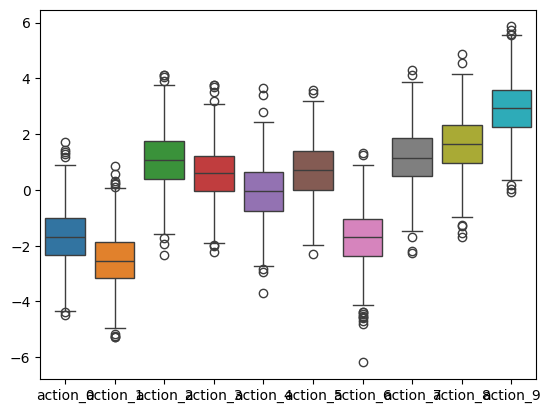

In [73]:
rd = RewardDistribution(k=10)
rd.plot()

In practical scenarios, the underlying probability distributions governing rewards are typically unknown to the decision-maker. Possessing such knowledge would, in theory, enable a strategist to exploit the system to maximal advantage, potentially yielding substantial financial gain. However, absent this omniscience, we must rely on strategic algorithms to approximate these hidden distributions. The $\epsilon$-greedy algorithm presents a methodological framework for such an approximation, iteratively balancing the exploration of new actions with the exploitation of known rewards to model the distribution as closely as possible without prior knowledge of its parameters.

## Epsilon bandit

In this model we will setup $k=10$ arm bandit for the system and compare four epsilon approaches (0.0, 0.01, 0.1, 0.5).

In [74]:
class EpsBandit:
    def __init__(self):
        self.eps = None
        self.k = None
        self.qa = None
        self.actions = None
        self.rd = None

    def set_epsilon(self, eps):
        self.eps = eps

    def set_reward_distribution(self, rd):
        self.rd = rd

    def set_k_arms(self, k):
        self.k = k

    def get_action_dist(self):
        return self.actions

    def get_q_values(self):
        return self.qa

    def _sample_an_action(self):

        def greedy_action():
            # pick action corresponding to high qa
            return np.argmax(self.qa)

        def random_action():
            # pick random action from k selections
            return np.random.choice(self.k)

        if self.eps == 0:
            # always greedy choice
            return greedy_action()
        else:
            p = np.random.rand()
            # high epsilon means more weight to random actions
            if p < self.eps:
                return random_action()
            else:
                return greedy_action()

    def _execute_an_action(self, action):
        sampled_rewards = self.rd.get_reward(action=action)
        self.actions[action] += 1
        return sampled_rewards
    
    
class Experiment(EpsBandit):
    def __init__(self, name):
        super().__init__()
        self.name = name
        self.total_avg_reward = 0.0
        self.average_rewards = {}

    def set_epsilon(self, eps):
        self.eps = eps

    def set_k_arms(self, k):
        self.k = k
        self.qa = np.zeros(k)
        self.actions = np.zeros(k)

    def set_reward_distribution(self, rd):
        self.rd = rd

    def get_name(self):
        return self.name

    def get_average_rewards(self):
        return pd.DataFrame(self.average_rewards)

    def get_action_dist(self):
        dataframe = {}
        for _index, value in enumerate(self.actions):
            dataframe[f'a{_index}'] = [value]
        return pd.DataFrame(dataframe)

    def get_q_values_dist(self):
        dataframe = {}
        for _index, value in enumerate(self.qa):
            dataframe[f'q_a{_index}'] = [value]
        return pd.DataFrame(dataframe)

    def run(self, steps=10):
        for t in range(1, steps):
            action = self._sample_an_action()
            r_t = self._execute_an_action(action)
            self.total_avg_reward = running_average(m_n_1=self.total_avg_reward, r_i=r_t, n=t)
            self.qa[action] = running_average(m_n_1=self.qa[action], r_i=r_t, n=self.actions[action])
            self.average_rewards[f't{t}'] = [round(float(self.total_avg_reward), 2)]

An $\epsilon$ value of 0.0 implies that we consistently select the greedy action, the one that has yielded the maximum reward in previous trials. Conversely, an $\epsilon$ value of 0.5 indicates a balanced approach: 50% of the time, we opt for the action that has provided the maximum rewards historically, and the remaining 50% of the time, we engage in exploration by selecting actions at random.

In [75]:
class Experiments:
    def __init__(self):
        self.time_steps = 10
        self.experiments = []

    def set_time_steps(self, steps=10):
        self.time_steps = steps

    def add_an_experiment(self, experiment):
        self.experiments.append(experiment)

    def run_all_experiments(self):
        for _experiment in self.experiments:
            _experiment.run(steps=self.time_steps)

    def get_results(self):
        results = dict()
        results['time_step'] = []
        results['epsilon'] = []
        results['average_reward'] = []
        for t in range(0, self.time_steps):
            for _exp in self.experiments:
                _res = _exp.get_average_rewards()
                results['time_step'].append(f't{t}')
                results['epsilon'].append(_exp.get_name())
                if t == 0:
                    results['average_reward'].append(0.0)
                else:
                    results['average_reward'].append(_res.loc[[0], [f't{t}']].values[0][0])
        return pd.DataFrame(results)


number_of_arms = 10
# One reward distribution comman across all 
reward_distribution = RewardDistribution(k=number_of_arms)

experiments = Experiments()
experiments.set_time_steps(steps=100)

experiment_1 = Experiment(name='eps_0')
experiment_1.set_k_arms(k=number_of_arms)
experiment_1.set_reward_distribution(rd=reward_distribution)
experiment_1.set_epsilon(eps=0.0)
experiments.add_an_experiment(experiment=experiment_1)

experiment_2 = Experiment(name='eps_0_0_1')
experiment_2.set_k_arms(k=number_of_arms)
experiment_2.set_reward_distribution(rd=reward_distribution)
experiment_2.set_epsilon(eps=0.01)
experiments.add_an_experiment(experiment=experiment_2)

experiment_3 = Experiment(name='eps_0_1')
experiment_3.set_k_arms(k=number_of_arms)
experiment_3.set_reward_distribution(rd=reward_distribution)
experiment_3.set_epsilon(eps=0.1)
experiments.add_an_experiment(experiment=experiment_3)

Ok, now let's run this experiment.

  time_step    epsilon  average_reward
0        t0      eps_0            0.00
1        t0  eps_0_0_1            0.00
2        t0    eps_0_1            0.00
3        t1      eps_0           -1.32
4        t1  eps_0_0_1           -1.42


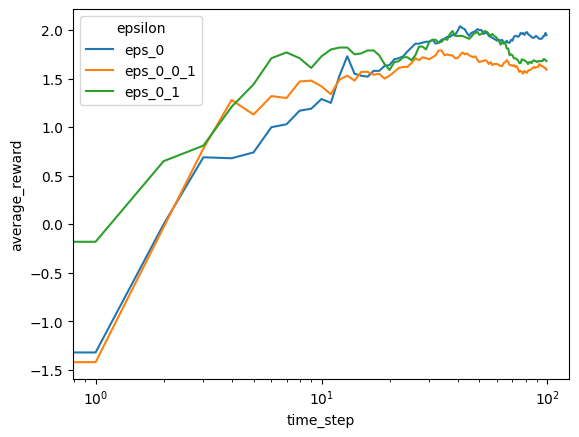

In [76]:
experiments.run_all_experiments()
results = experiments.get_results()
print(results.head())
sns.lineplot(data=results, x='time_step', y='average_reward', hue='epsilon')
plt.xscale('log')

The experiment was conducted over a time span of 1,000 timesteps, during which we collected the running average rewards for various values of $\epsilon$. As we repeat these experiments our <b>Q</b> values will converge to <b>Q*</b> values.

## Running episodes

It is important to note that the reward distribution was sampled once using the RewardDistribution class and this sample was utilized across various experiments with differing values of $\epsilon$. To ensure the robustness of our findings and to allow our estimated values to converge reliably to the optimal values, it is imperative to replicate this experiment multiple times, each with a unique instantiation of the reward distribution.

  time_step    epsilon  average_reward
0        t0      eps_0        0.000000
1        t0  eps_0_0_1        0.000000
2        t0    eps_0_1        0.000000
3        t1      eps_0        1.961414
4        t1  eps_0_0_1        1.704545


<Axes: xlabel='time_step', ylabel='average_reward'>

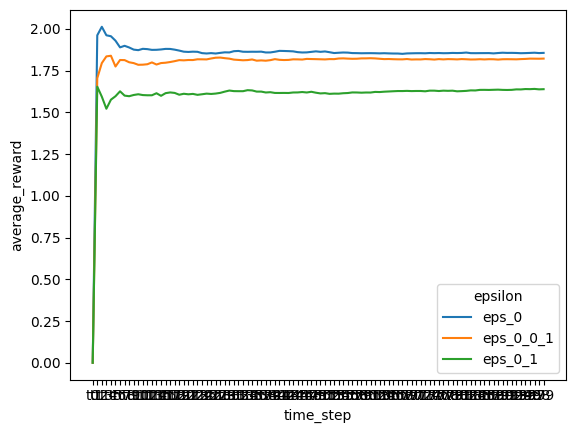

In [77]:
net_result = None
flag = False
for episode in range(0, 100):
    experiments.run_all_experiments()
    results = experiments.get_results()
    if not flag:
        net_result = results
        flag = True
    else:
        net_result['average_reward'] = running_average(m_n_1=net_result['average_reward'],
                                                       r_i=results['average_reward'],
                                                       n=episode)
print(net_result.head())
sns.lineplot(data=net_result, x='time_step', y='average_reward', hue='epsilon')

Now that we have the data we need, we shall format it and prepare for plotting.

## Optimistic Initial Values in non stationary environments

In academic literatures we usually model these average estimates as <b>$Q$</b> values. Using a similar definition as above let <b>$R_i$</b> now denote reward received after the <b>$i^ith$</b> iteration for a given action. Let <b>$Q_n$</b> denote the estimate of its action value after it has been selected <b>$n-1$</b> times then

\begin{equation*}
Q_n = \frac{R_1+R_2+R_3+....+R_n-1}{n-1}
\end{equation*}

From the derivation made using running averages we can say

\begin{equation*}
Q_{n+1} = Q_n + \frac{1}{n}*(R_n-Q_n)
\end{equation*}

This can be informally viewed as this

<b>New Estimate</b> $\leftarrow$ <b>Old Estimate</b> + <b>Step Size</b> (<b>Target</b> - <b>Old Estimate</b>)

The methods discussed so far are dependent to some extent on the initial Q values, ie, $Q_1(a)$. In other words these methods are biases with initial values of $Q$. The bias will disappear when all actions are samples infinite time by the law of large numbers. On the other hand in the methods discussed so far we assumed that the environment is fixed with a stationary reward distribution. However, we know that in real world reward distribution keep changing. So to model this problem we need the agent to be encouraged to explore more based on the environment dynamics. As number of iterations run towards infinity $\frac{1}{n}$ tends towards 0. Which means for large iterations we can model $\frac{1}{n}$ as a fraction close to 0. We shall represent this by alpha $\alpha$ where $\alpha \in (0, 1]$

\begin{equation*}
Q_{n+1} = Q_n + \alpha*(R_n-Q_n)
\end{equation*}

Since, the step-size parameter $\alpha$ is constant we can derive the following.

\begin{equation*}
Q_{n+1} = \alpha * R_n + (1-\alpha) * Q_{n}
\end{equation*}

\begin{equation*}
Q_{n+1} = \alpha * R_n + (1-\alpha) * (\alpha * R_{n-1}+(1-\alpha) * Q_{n-1})
\end{equation*}

\begin{equation*}
Q_{n+1} = \alpha * R_n + (1-\alpha) * \alpha * R_{n-1} + (1-\alpha)^{2} * Q_{n-1}
\end{equation*}

\begin{equation*}
Q_{n+1} = \alpha * R_n + (1-\alpha) * \alpha * R_{n-1} + (1-\alpha)^{2} * \alpha * R_{n-2} + ... + (1-\alpha)^{n-1}\alpha* R_{n-1}+(1-\alpha)^{n} * Q_{1}
\end{equation*}

\begin{equation*}
Q_{n+1} = (1-\alpha)^{n} * Q_{1} + \sum_{i=1}^n (1-\alpha)^{n-i}*R_{i}
\end{equation*}

Modeling $\frac{1}{n}$ as $\alpha$ indicate that the system will never converge but hover around the near optimal values and this can be a desirable property in a non stationary rewards enviroment.

## Upper confidence bound

In this model we will use same setup $k=10$ arm bandit for the system and compare four epsilon approaches (0.0, 0.01, 0.1) with upper confidence bound. e-greedy action selection forces the non-greedy actions to be tried, but indiscriminately, with no preferance for those of near greedy. We need to taken into account how close estimates are for other actions too. 

\begin{equation*}
A_t = argmax(Q_t(a)+c*\sqrt{\frac{ln(t)}{N_t(a)}})
\end{equation*}

$ln(t)$ denotes the natural logarithm of time steps and $N_t(a)$ represents number of times an action was chosen. In the above equation the square root term measures the uncertainity or variance in the estimates of action values. And $c$ represents the confidence in those estimates.

<Axes: xlabel='time_step', ylabel='average_reward'>

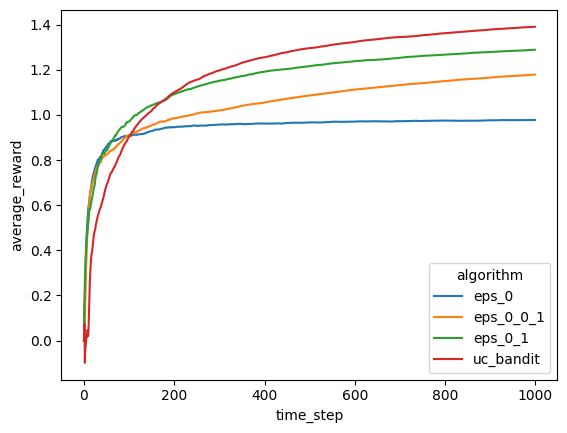

In [78]:
class EpsBandit:
    def __init__(self, rd, k=10, eps=0.0, iterations=10):
        self.k = k
        self.eps = eps
        self.total_avg_reward = 0.0
        self.qa = np.zeros(self.k)
        self.ac = np.zeros(self.k)
        self.iterations = iterations
        self.rd = rd

    def sample_an_action(self):

        def greedy_action():
            # pick action corresponding to high qa
            return np.argmax(self.qa)

        def random_action():
            # pick random action from k selections
            return np.random.choice(self.k)

        if self.eps == 0:
            # always greedy choice
            return greedy_action()
        else:
            p = np.random.rand()
            # high epsilon means more weight to random actions
            if p < self.eps:
                return random_action()
            else:
                return greedy_action()

    def execute_an_action(self, action):
        sampled_rewards = self.rd.get_reward(action=action)
        self.ac[action] += 1
        return sampled_rewards

    def log(self, t, action, r_t):
        print(f'==== step {t} ====')
        print(f'Sampled a reward {r_t} for action A_{action}')
        print(f'Tr {self.total_avg_reward}')
        print(f'qa {self.qa}')
        print(f'ac {self.ac}')
        print('\n')

    def get_total_average_rewards(self):
        return self.total_avg_reward

    def run(self):

        avg_reward = [0.0]
        for t in range(1, self.iterations):
            action = self.sample_an_action()
            r_t = self.execute_an_action(action)
            self.total_avg_reward = running_average(m_n_1=self.total_avg_reward, r_i=r_t, n=t)
            self.qa[action] = running_average(m_n_1=self.qa[action], r_i=r_t, n=self.ac[action])
            avg_reward.append(float(self.total_avg_reward))
            # self.log(t, action, r_t)
        return avg_reward


class UCBandit:
    def __init__(self, rd, k, iterations):
        self.k = k
        self.total_avg_reward = 0.0
        self.qa = np.zeros(self.k)
        self.ac = np.ones(self.k)
        self.iterations = iterations
        self.rd = rd
        self.c = 2
    
    def sample_an_action(self):
        uncertainity = np.log(self.iterations)/self.ac
        uc = self.c * np.sqrt(uncertainity)
        return np.argmax(self.qa+uc)

    def execute_an_action(self, action):
        sampled_rewards = self.rd.get_reward(action=action)
        self.ac[action] += 1
        return sampled_rewards

    def log(self, t, action, r_t):
        print(f'==== step {t} ====')
        print(f'Sampled a reward {r_t} for action A_{action}')
        print(f'Tr {self.total_avg_reward}')
        print(f'qa {self.qa}')
        print(f'ac {self.ac}')
        print('\n')

    def get_total_average_rewards(self):
        return self.total_avg_reward
    
    def get_action_dist(self):
        return self.ac
    
    def run(self):
        avg_reward = [0.0]
        for t in range(1, self.iterations):
            action = self.sample_an_action()
            r_t = self.execute_an_action(action)
            self.total_avg_reward = running_average(m_n_1=self.total_avg_reward, r_i=r_t, n=t)
            self.qa[action] = running_average(m_n_1=self.qa[action], r_i=r_t, n=self.ac[action])
            avg_reward.append(float(self.total_avg_reward))
            #self.log(t, action, r_t)
        return avg_reward
                         
def run_experiment(k=5, iterations=1000):
    rd = RewardDistribution(k=k)
    #rd.plot()
    data = {}
    
    fmt = lambda i, eps, cnt: {'action': f"action_{i}", 'count': cnt, 'epsilon': f"eps_{eps}"}
    
    eps_0 = EpsBandit(rd=rd, k=k, eps=0.0, iterations=iterations)
    data['eps_0'] = eps_0.run()

    eps_0_0_1 = EpsBandit(rd=rd, k=k, eps=0.01, iterations=iterations)
    data['eps_0_0_1'] = eps_0_0_1.run()

    eps_0_1 = EpsBandit(rd=rd, k=k, eps=0.1, iterations=iterations)
    data['eps_0_1'] = eps_0_1.run()
    
    uc_bandit = UCBandit(rd=rd, k=k, iterations=iterations)
    data['uc_bandit'] = uc_bandit.run()

    return pd.DataFrame(data)

df = run_experiment()

def run_episodes(episodes=1000):
    result = dict()
    iterations = 1000
    result['eps_0'] = np.zeros(iterations)
    result['eps_0_0_1'] = np.zeros(iterations)
    result['eps_0_1'] = np.zeros(iterations)
    result['uc_bandit'] = np.zeros(iterations)
    for episode in range(1, episodes):
        df = run_experiment(k=10, iterations=iterations)
        result['eps_0'] = running_average(m_n_1=result['eps_0'], r_i=np.asarray(df['eps_0']), n=episode)
        result['eps_0_0_1'] = running_average(m_n_1=result['eps_0_0_1'], r_i=np.asarray(df['eps_0_0_1']), n=episode)
        result['eps_0_1'] = running_average(m_n_1=result['eps_0_1'], r_i=np.asarray(df['eps_0_1']), n=episode)
        result['uc_bandit'] = running_average(m_n_1=result['uc_bandit'], r_i=np.asarray(df['uc_bandit']), n=episode)
        _df = pd.DataFrame(result)
    return _df

def prepare_data_for_plotting(_df):
    entries = []
    for time_step in range(0, 1000):
        entries.append({'time_step': time_step, 'algorithm': 'eps_0', 'average_reward': _df['eps_0'][time_step]})
        entries.append({'time_step': time_step, 'algorithm': 'eps_0_0_1', 'average_reward': _df['eps_0_0_1'][time_step]})
        entries.append({'time_step': time_step, 'algorithm': 'eps_0_1', 'average_reward': _df['eps_0_1'][time_step]})
        entries.append({'time_step': time_step, 'algorithm': 'uc_bandit', 'average_reward': _df['uc_bandit'][time_step]})
    dframe = pd.DataFrame(entries)
    return dframe
    
_df = run_episodes(episodes=100)
dframe = prepare_data_for_plotting(_df)

sns.lineplot(data=dframe, x='time_step', y='average_reward', hue='algorithm')

## Associative Search (Contextual Bandits)

Associative search is characterized by a dual-process mechanism: it encompasses both trial-and-error learning to identify optimal actions and the formation of associations between these actions and the specific contexts in which they prove to be most effective. This type of search task serves as an intermediary complexity level, situated between the k-armed bandit problem and the broader domain of reinforcement learning. The detailed exploration of associative search algorithms is extensive and falls outside the purview of this article. However, a thorough examination is planned for subsequent publications.

## Conclusion

This article has delineated the exploration-exploitation dilemma and contextualized its relevance in practical applications. Through empirical investigation, we have substantiated that near-greedy approaches yield efficacious results within the framework of epsilon-greedy algorithms. Moreover, it has been established that Upper Confidence Bound (UCB) algorithms outperform epsilon-greedy strategies, albeit predominantly within stationary environments. The foundational concepts pertinent to associative search, also known as contextual bandits, have been introduced, setting the stage for their detailed exploration in future work.